In [1]:
%matplotlib inline  

import gym
import gym_easy21
import numpy as np
from collections import defaultdict

### Random walk to test Easy21Env

In [2]:
env = gym.make("Easy21-v0")

episodes = 1
T = 1

for eps in range(episodes):
    obs = env.reset()
    print("Initial score ", obs)
    for t in range(T):
        action = env.action_space.sample()
        print("Choose " + ("stick" if action == 0 else "hit"))
        obs, reward, done, _ = env.step(action)
        print("Time step {}: ".format(t), obs, reward)
        if done:
            print("Episode {0} ends at time step {1}".format(eps, t))
            break

Initial score  (8, 6)
Choose stick
Time step 0:  (8, 19) -1
Episode 0 ends at time step 0


C:\Users\An\Anaconda3\envs\rl\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Utilities for plotting 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# for plotting value func, we choose max value of action-value func (possible due to GLIE)
def get_value_and_deterministic_policy(Q, policy):
    V = []
    pi = np.zeros((21, 10))
    for state in Q:
        greedy_action = np.argmax(policy(state))
        V.append((state[0], state[1], Q[state][greedy_action]))
        pi[state[0] - 1][state[1] - 1] = greedy_action
    return V, pi

def plot_value_fn_and_policy(V, pi, num_episode, i):
    df = pd.DataFrame(V)
    fig = plt.figure(i, figsize=(20, 10))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_trisurf(df[1], df[0], df[2], cmap=plt.cm.viridis, linewidth=0.2)
    ax1.set(xlabel='Dealer score', ylabel='Player score', title="Value func MC control {} episodes".format(num_episode))
    
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(pi, square=True, xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 21), ax = ax2)
    ax2.invert_yaxis()
    ax2.set(xlabel='Dealer score', ylabel='Player score', title="Policy MC control {} episodes".format(num_episode))

### Every-visit Monte-Carlo Control with eps-greedy policy

In [24]:
def eps_greedy_policy(Q, nA, N, N0=100):
    def policy(state):
        action_values = Q[state]
        greedy_action = np.argmax(action_values)
        eps = N0 / (N0 + N[state])
        action_prob = np.ones(nA) * eps / nA
        action_prob[greedy_action] += (1 - eps)
        return  action_prob
    return policy

def monte_carlo_control_on_policy(env, num_episode, discount_factor=1.0):
    nA = env.action_space.n # action set size of env
    
    N = defaultdict(int) # count number of visits of each state and state-action pair
    
    # initialize action-value func and e-greedy policy
    Q = defaultdict(lambda: np.zeros(nA))
    policy = eps_greedy_policy(Q, nA, N)
    
    for episode in range(1, num_episode + 1):
        state = env.reset()
        
        done = False
        eligibility_traces = defaultdict(float) # for tracking return of visited states
        returns = defaultdict(float) # return of each state-action pair
        
        while not done:
            action = np.random.choice(nA, p=policy(state))
            state_action = (state, action)
            
            # update routine of discount factor 
            for _state_action in eligibility_traces:
                eligibility_traces[_state_action] *= discount_factor
            
            # everytime we visit a state, increase one count
            eligibility_traces[state_action] += 1.0
            N[state_action] += 1
            N[state] += 1
            
            next_state, reward, done, _ = env.step(action)
            
            for _state_action in eligibility_traces:
                returns[_state_action] += eligibility_traces[_state_action] * reward
            
            state = next_state
        
        # update action-value func following GLIE schedule
        for state, action in returns:
            Q[state][action] += (1 / N[(state, action)]) * (returns[(state, action)] - Q[state][action])
        
        # improve policy
        policy = eps_greedy_policy(Q, nA, N)
    return Q, policy

We will try MC-control with eps-greedy on 100000 and 500000 episodes to see how value function and policy function evolve.   

In [67]:
env = gym.make("Easy21-v0")

# try 100000 episodes
num_episode = 100000
Q1, policy1 = monte_carlo_control_on_policy(env, num_episode)
V1, pi1 = get_value_and_deterministic_policy(Q1, policy1)

# try 500000 episodes
num_episode = 500000
Q2, policy2 = monte_carlo_control_on_policy(env, num_episode)
V2, pi2 = get_value_and_deterministic_policy(Q2, policy2)

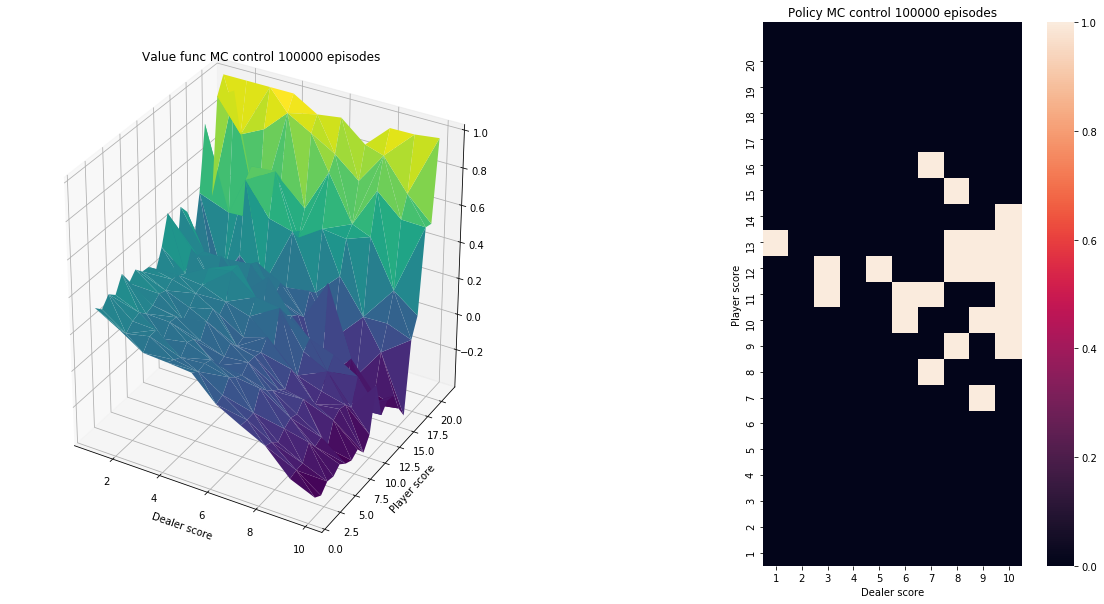

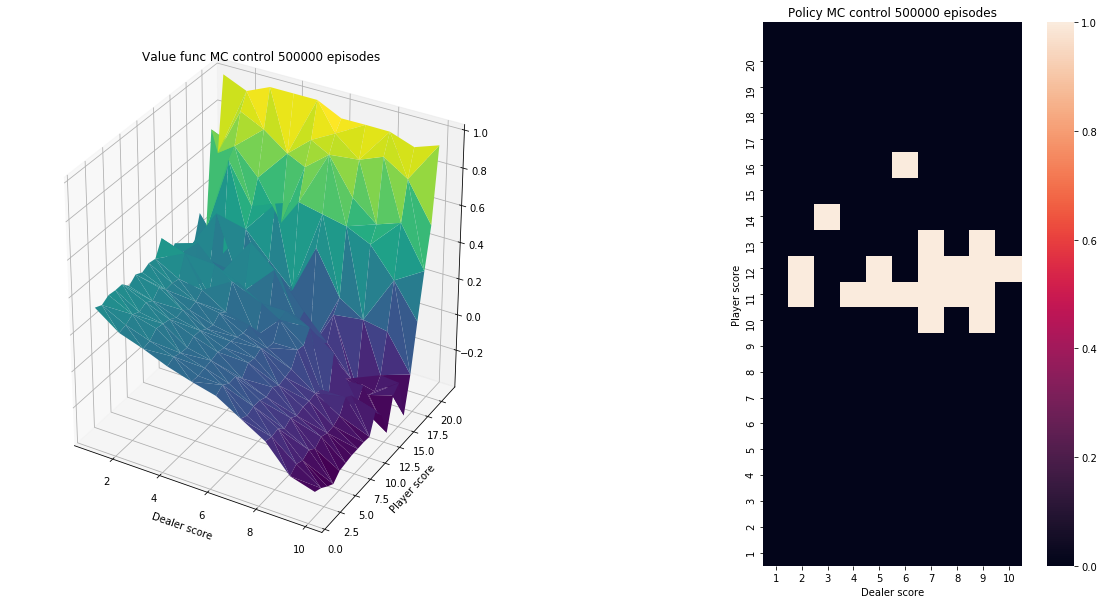

In [68]:
plot_value_fn_and_policy(V1, pi1, 100000, 1)
plot_value_fn_and_policy(V2, pi2, 500000, 2)
plt.show()

### Temporal-Difference Control (TD Sarsa) 